 # CITE-seq cytokine expression

In [1]:
library(tidyverse)
library(magrittr)
library(purrr)

library(ggplot2)
library(patchwork)
library(ggvenn)
theme_set(theme_bw(base_size=12) + theme(panel.grid=element_blank(), 
                             panel.border=element_blank(), 
                             axis.title=element_blank(), 
                             axis.text=element_blank(), 
                             axis.line = element_line(arrow=arrow(length=unit(2, "mm"))),
                             strip.text = element_text(size=12),
                             strip.background=element_blank()))

library(Matrix)

library(SingleCellExperiment)
library(scran)
library(scater)

library(scutility)
library(multisce)

library(pheatmap)

Warning message:
“package ‘tidyverse’ was built under R version 4.3.2”
Warning message:
“package ‘tibble’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘forcats’ was built under R version 4.3.2”
Warning message:
“package ‘lubridate’ was built under R version 4.3.2”
── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.0.10     ✔ readr     2.1.4 
✔ forcats   1.0.0      ✔ stringr   1.5.0 
✔ ggplot2   3.4.2      ✔ tibble    3.2.1 
✔ lubridate 1.9.3      ✔ tidyr     1.2.1 
✔ purrr     0.3.4      
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_c

In [2]:
sce <- multisce_load(path=here::here("data", "multisce", "SS17_blood"), main_name="RNA", reduceddim_include="umap", metadata_include="colors")

Loading RNA from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/sce/RNA.rds

Loading coldata from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/coldata.rds

Loading colors from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/metadata/colors.rds

Loading umap from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/reducedDim/umap.rds



In [4]:
group_to_short <- c("PBS_DMSO"="Veh",
                    "PBS_Romidepsin"="Ro",
                    "SE_DMSO"="SE",
                    "SE_Romidepsin"="SE+Ro")

sce$group_short <- group_to_short[as.character(sce$group)]

metadata(sce)$colors[["group_short"]] <- c("Veh"="grey", "Ro"="#009900", "SE"="#CC0000", "SE+Ro"="orange")

sce$group_short %<>% factor(levels=names(metadata(sce)$colors[["group_short"]]))

In [5]:
sce$cell_type %<>% factor(levels=names(metadata(sce)$colors$cell_type))

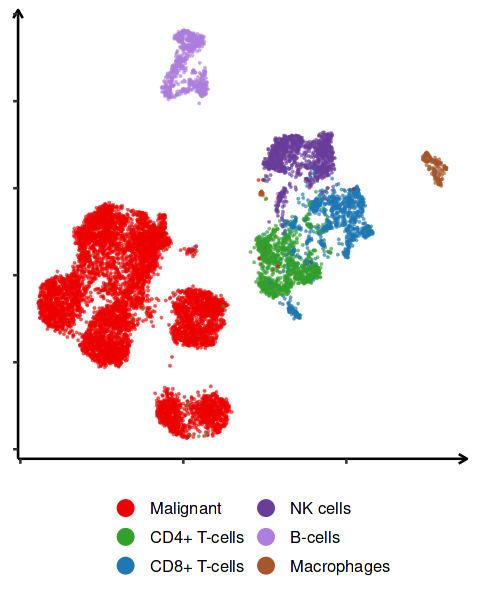

In [6]:
options(repr.plot.width=4, repr.plot.height=5)
scutility::plot_dimred(sce, dimred="umap", rasterise=TRUE,
                           point_size=0.25, point_alpha=0.5, shuffle=TRUE, 
                           scale_color=scale_color_manual(values=metadata(sce)$colors[["cell_type"]] %>% .[names(.) %in% unique(sce$cell_type)]), 
                           colour_by="cell_type") + 
                       guides(color=guide_legend(ncol=2, override.aes=list(alpha=1, size=4))) + 
                       theme(legend.position="bottom", aspect.ratio=1, legend.title=element_blank()) 


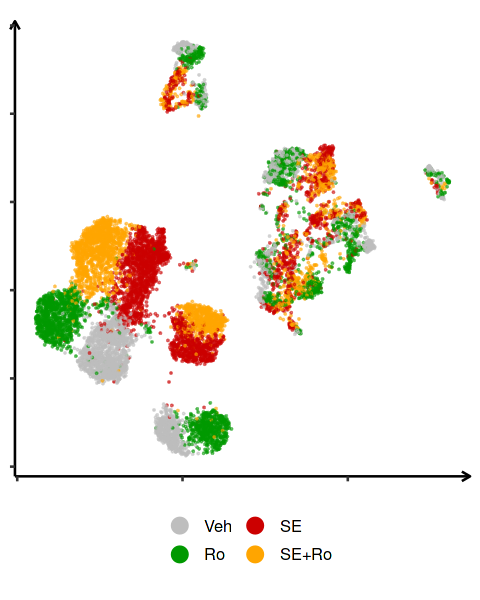

In [7]:
options(repr.plot.width=4, repr.plot.height=5)
scutility::plot_dimred(sce, dimred="umap",rasterise=TRUE,
                           point_size=0.25, point_alpha=0.5, shuffle=TRUE, 
                           scale_color=scale_color_manual(values=metadata(sce)$colors[["group_short"]]), 
                           colour_by="group_short") + 
                       guides(color=guide_legend(ncol=2, override.aes=list(alpha=1, size=4))) + 
                       theme(legend.position="bottom", aspect.ratio=1, legend.title=element_blank()) 

Joining, by = "BC"
`summarise()` has grouped output by 'group_short'. You can override using the `.groups` argument.


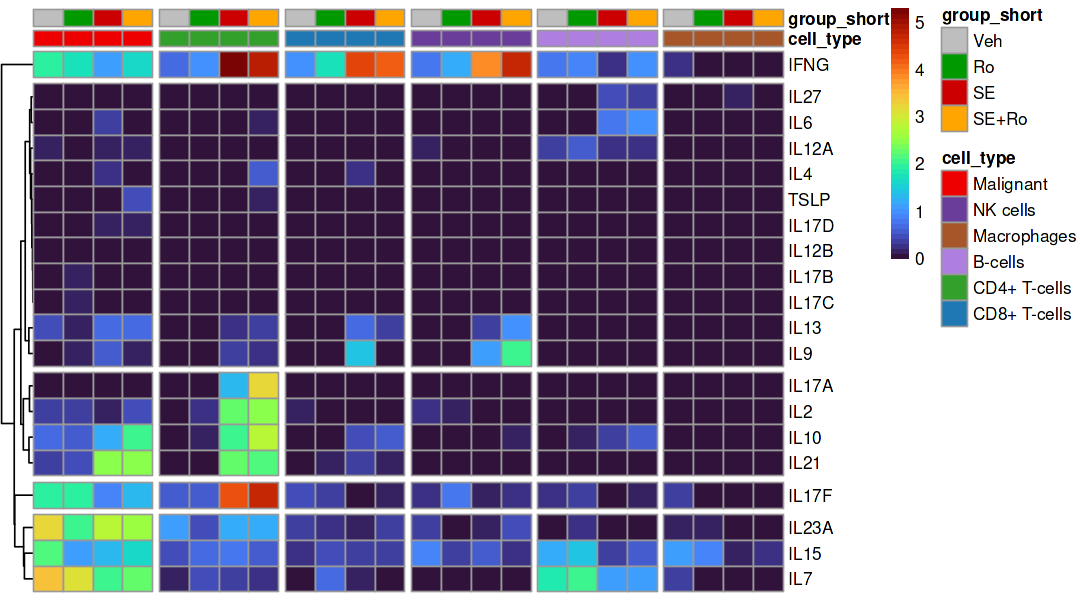

In [8]:
cytokines <- c("IL17A", "IL17B", "IL17C", "IL17D", "IL17F", "IL27", "IL23A", "IL13", "IL2", "IL10", "IFNG", "IL6", "IL12A", "IL21", "IL12B", "IL9", "IL15", "TSLP", "IL4", "IL7")

data_plot <- colData(sce)[, c("group_short", "cell_type", "sum"), drop=FALSE] %>% as.data.frame() %>% dplyr::rename(total=sum) %>% tibble::rownames_to_column("BC") %>% 
    left_join(counts(sce)[cytokines, , drop=FALSE] %>% t() %>% as.data.frame() %>% tibble::rownames_to_column("BC")) %>% 
    group_by(group_short, cell_type) %>% summarize(across(all_of(unname(cytokines)), sum), count=n(), total=sum(total)) %>% 
    group_by(group_short) %>% mutate(sample_total=sum(total)) %>% ungroup() %>% 
    mutate(across(all_of(unname(cytokines)), function(x){x/(sample_total/10^6)})) %>% 
    arrange(cell_type, group_short) %>% 
    mutate(group=paste(cell_type, group_short, sep="_")) %>% select(-c(group_short, cell_type, count, total, sample_total)) %>% 
    column_to_rownames("group") %>% as.matrix

ann <- data.frame(sample=rownames(data_plot), row.names = rownames(data_plot)) %>% separate(col="sample", into=c("cell_type","group_short"), sep="_")
ann_colors <- metadata(sce)$colors[c("cell_type", "group_short")]
ann_colors[["group_short"]] %<>% .[names(.) != "Skin"]
ann_colors$cell_type %<>% .[unique(sce$cell_type)]

options(repr.plot.width=9, repr.plot.height=5)
data_plot %>% as.matrix %>% t %>% log1p %>% 
    pheatmap(cluster_col=FALSE, gaps_col=1:5*4, treeheight_row = 15,
             show_colnames=FALSE,
             cutree_rows=5, 
             color=viridisLite::turbo(50), annotation_col=ann, annotation_colors=ann_colors) %>% 
    ggplotify::as.ggplot() %>% ggsave(filename="data/scRNAseq_cytokines.pdf", height=5, width=9)